# Interpretability of CNN

We have learned that convolutional kernels in CNNs learn local patterns in images, but in general, the learned kernels of CNNs are rarely interpretable by humans. Nevertheless, very simple toy problems can sometimes show interpretable learning results. In this assignment, we will train a CNN classifier on a very simple dataset, the MNIST handwriting dataset, and examine the learned kernels.

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Tiny toy problem

Generate images with horizontal and vertical lines and train a CNN model to classify whether the image has horizontal or vertical lines.

In [2]:
class LineDataset(Dataset):
    """Synthetic images containing a single horizontal or vertical line."""
    def __init__(self, n_samples: int = 1000, img_size: int = 16):
        self.img_size = img_size
        self.X = []
        self.y = []
        rng = np.random.default_rng(seed=0)

        for _ in range(n_samples):
            img = np.zeros((img_size, img_size), dtype=np.float32)
            if rng.random() < 0.5:
                # class 0: horizontal line
                row = rng.integers(0, img_size)
                img[row, :] = 1.0
                label = 0
            else:
                # class 1: vertical line
                col = rng.integers(0, img_size)
                img[:, col] = 1.0
                label = 1

            img += 0.05 * rng.standard_normal(size=img.shape)
            img = np.clip(img, 0, 1)

            self.X.append(img[None, :, :])  # (1, H, W)
            self.y.append(label)

        self.X = torch.tensor(self.X)
        self.y = torch.tensor(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

C:\Users\pco0511\AppData\Local\Temp\ipykernel_38888\2378841583.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.X = torch.tensor(self.X)


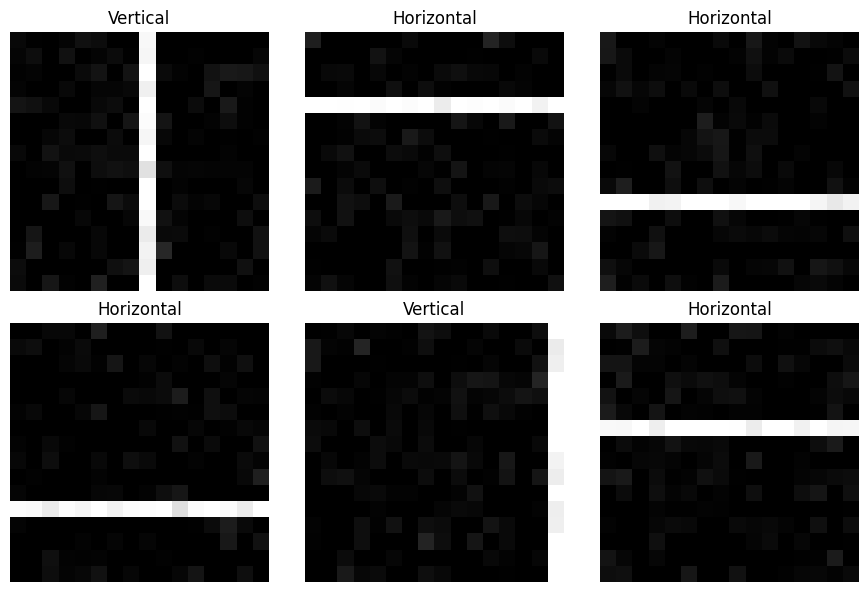

In [3]:
line_dataset = LineDataset(n_samples=6, img_size=16)
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for (img, label), ax in zip(line_dataset, axes.flatten()):
    ax.imshow(img[0], cmap='gray')
    ax.set_title('Vertical' if label == 1 else 'Horizontal')
    ax.axis('off')
plt.tight_layout()
plt.show()

Model definitions and functions for training the model.

In [4]:

class TinyCNN(nn.Module):
    """A CNN with just two 3×3 kernels to keep things interpretable."""

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 2, kernel_size=3, padding=1, bias=False)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(2 * 8 * 8, 2)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.flatten(start_dim=1)
        return self.fc(x)

def train(model: nn.Module, loader: DataLoader, device: torch.device,
          epochs: int = 20, lr: float = 1e-3):
    optimiser = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimiser.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * imgs.size(0)
        print(f"Epoch {epoch + 1}: loss = {running_loss / len(loader.dataset):.4f}")

def visualise_kernels(model: nn.Module, title: str = ""): 
    with torch.no_grad():
        kernels = model.conv.weight.cpu().numpy()
    n = kernels.shape[0]
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(kernels[i, 0], cmap="gray")
        ax.set_title(f"{title} Kernel {i}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

1. Train a CNN classifier using the above functions and plot the trained kernel.

Epoch 1: loss = 0.6563
Epoch 2: loss = 0.4825
Epoch 3: loss = 0.2462
Epoch 4: loss = 0.1214
Epoch 5: loss = 0.0639
Epoch 6: loss = 0.0316
Epoch 7: loss = 0.0192
Epoch 8: loss = 0.0129
Epoch 9: loss = 0.0093
Epoch 10: loss = 0.0071
Epoch 11: loss = 0.0056
Epoch 12: loss = 0.0045
Epoch 13: loss = 0.0037
Epoch 14: loss = 0.0031
Epoch 15: loss = 0.0027
Epoch 16: loss = 0.0023
Epoch 17: loss = 0.0020
Epoch 18: loss = 0.0018
Epoch 19: loss = 0.0016
Epoch 20: loss = 0.0014


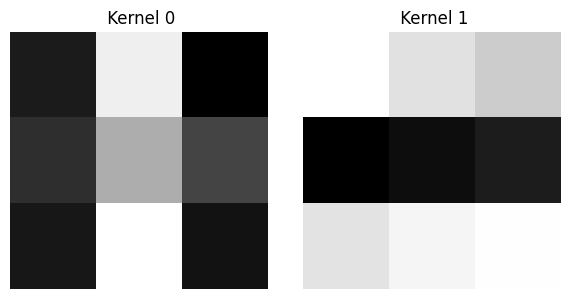

In [5]:
dataset = LineDataset(n_samples=2000, img_size=16)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# TODO: Train the model and visualise the kernels
model = TinyCNN()
train(model, loader, device)
visualise_kernels(model)

## MNIST dataset

Train a CNN classifier on handwritten data from 0 to 9. Load and use the MNIST dataset.

In [6]:
# Dataset and DataLoader for MNIST
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
train_loader = DataLoader(mnist_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(
    datasets.MNIST(root='./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=False
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.67MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 98.1kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 348kB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


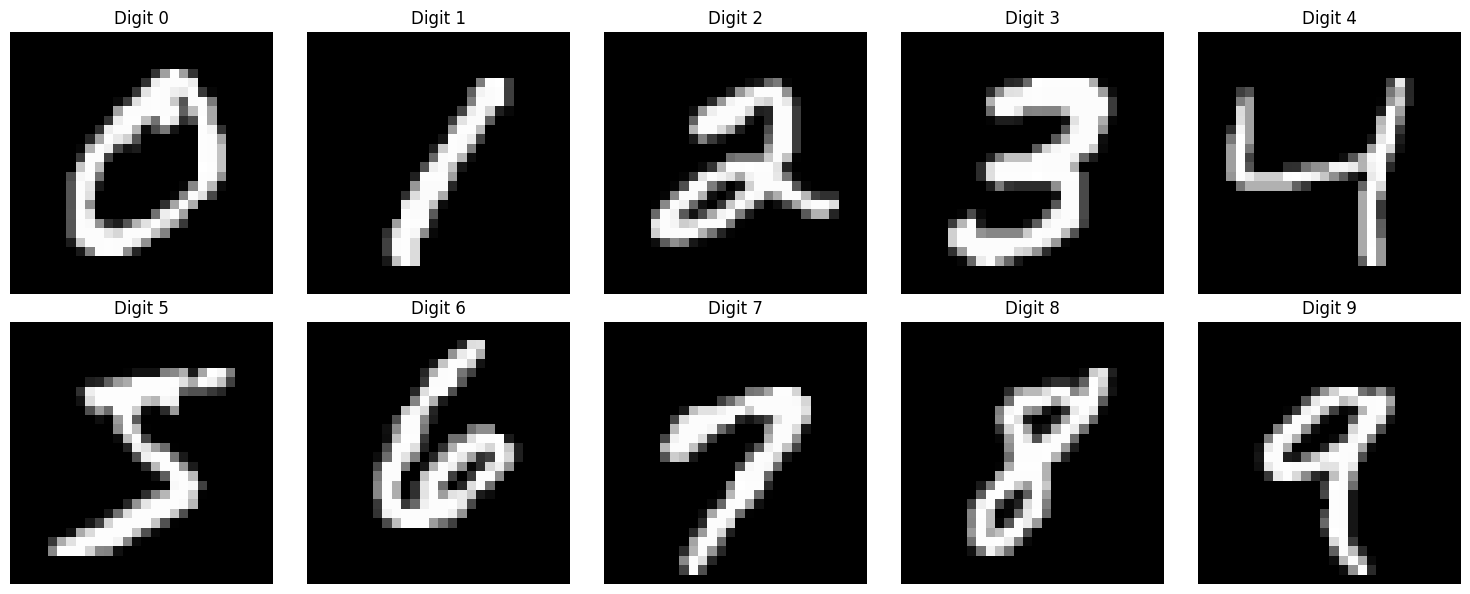

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for digit in range(10):
    idxs = (mnist_dataset.targets == digit).nonzero()
    idx = idxs[0].item()
    img = mnist_dataset.data[idx]
    ax = axes[digit // 5, digit % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Digit {digit}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 4, kernel_size=5, padding=2, bias=False)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc   = nn.Linear(4 * 14 * 14, 10)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

2. Train CNNClassifier and plot the trained kernel.

Epoch 1: loss = 0.3719
Epoch 2: loss = 0.1460
Epoch 3: loss = 0.1085
Epoch 4: loss = 0.0930
Epoch 5: loss = 0.0821
Epoch 6: loss = 0.0733
Epoch 7: loss = 0.0680
Epoch 8: loss = 0.0652
Epoch 9: loss = 0.0608
Epoch 10: loss = 0.0566


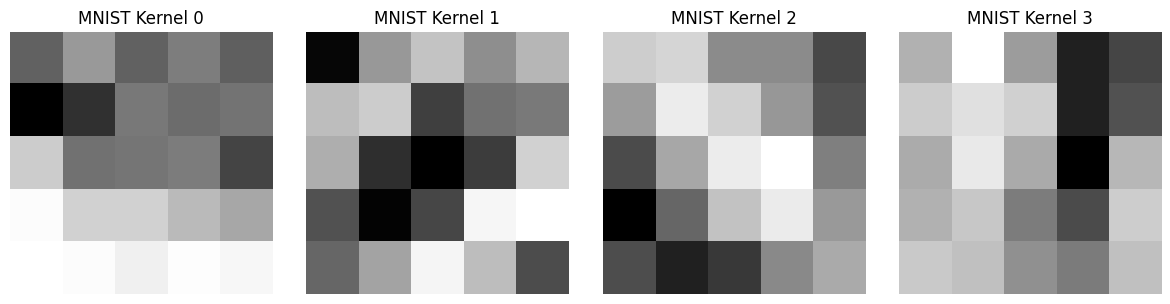

In [9]:
# TODO: Train the CNN model and visualise the kernels use train_loader for training

mnist_model = CNNClassifier().to(device)
train(mnist_model, train_loader, device, epochs=10)
visualise_kernels(mnist_model, title="MNIST")

In [10]:
mnist_model.eval()
correct = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        pred = mnist_model(imgs).argmax(dim=1)
        correct += pred.eq(labels).sum().item()
print(f"Test accuracy: {100. * correct / len(test_loader.dataset):.2f}%")

Test accuracy: 97.94%


Does the training succeed? Is the trained kernel interpretable?